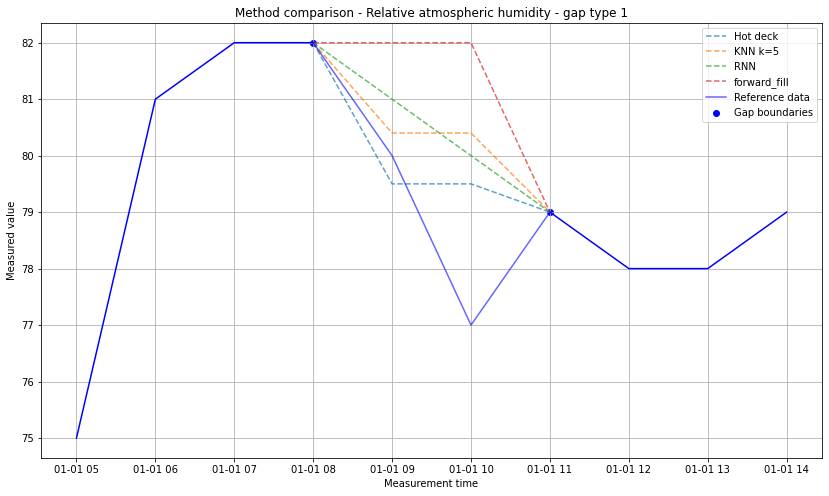

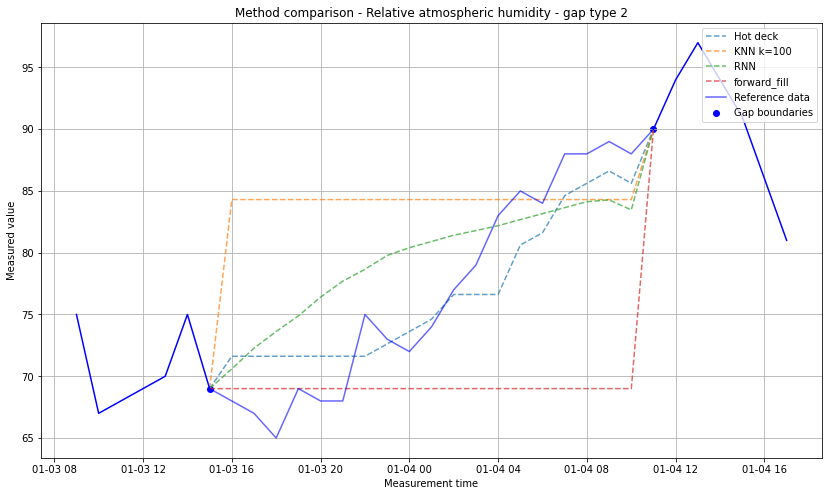

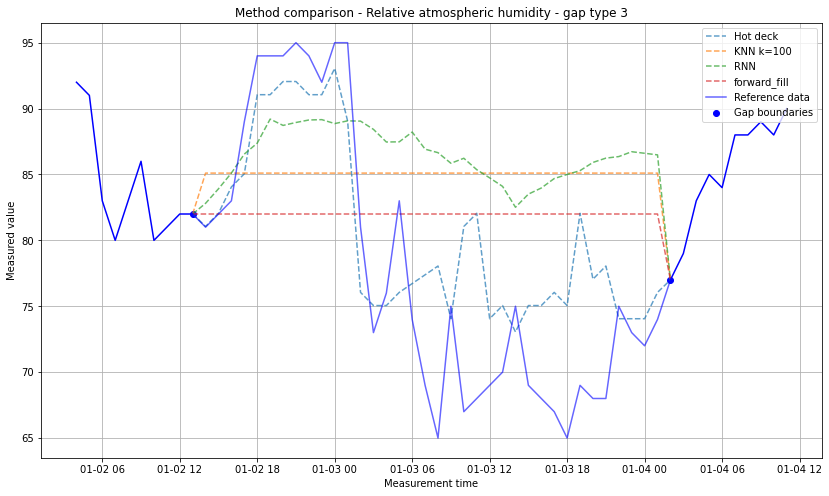

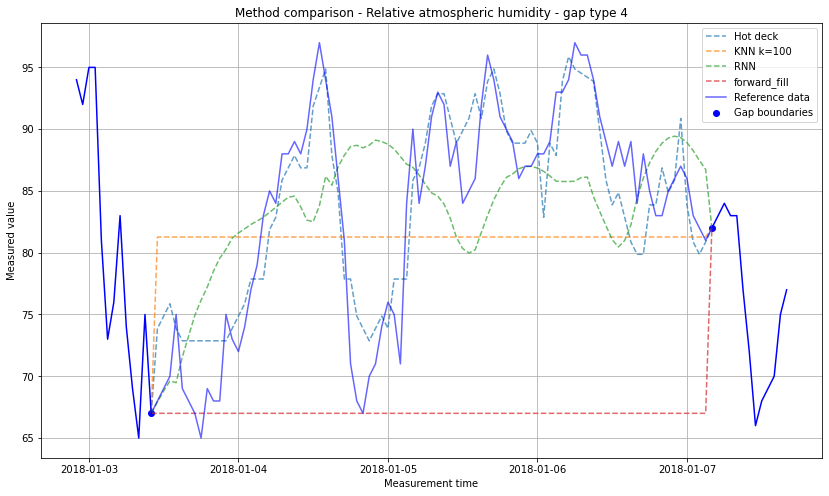

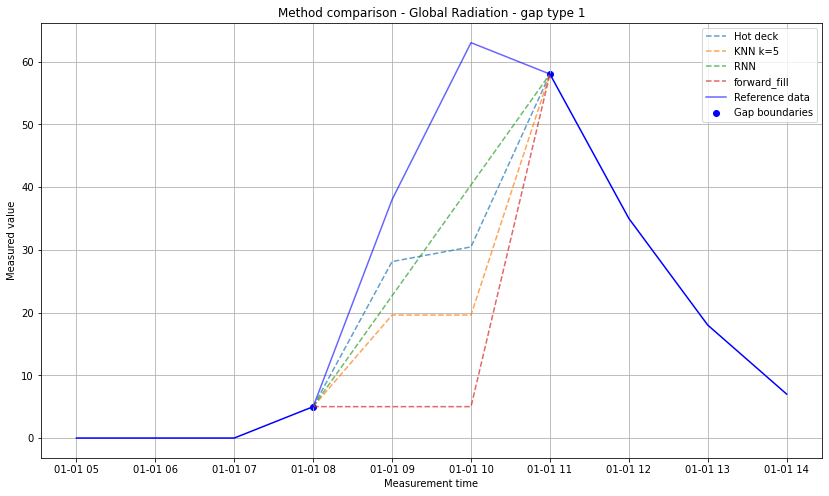

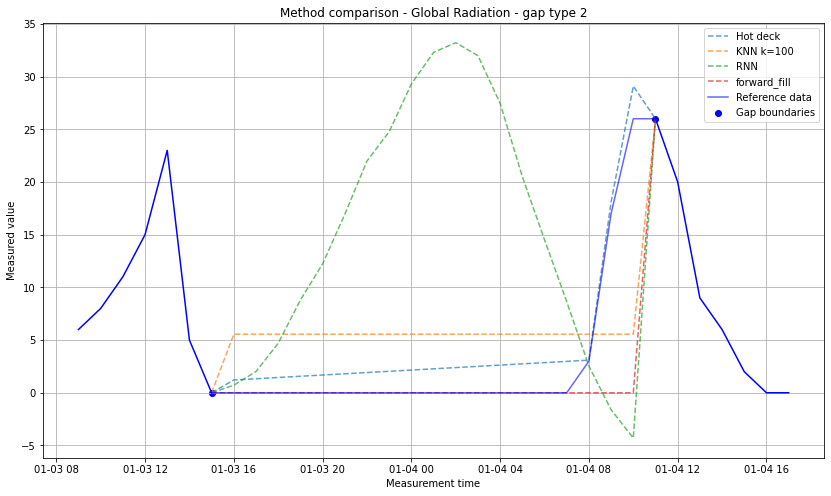

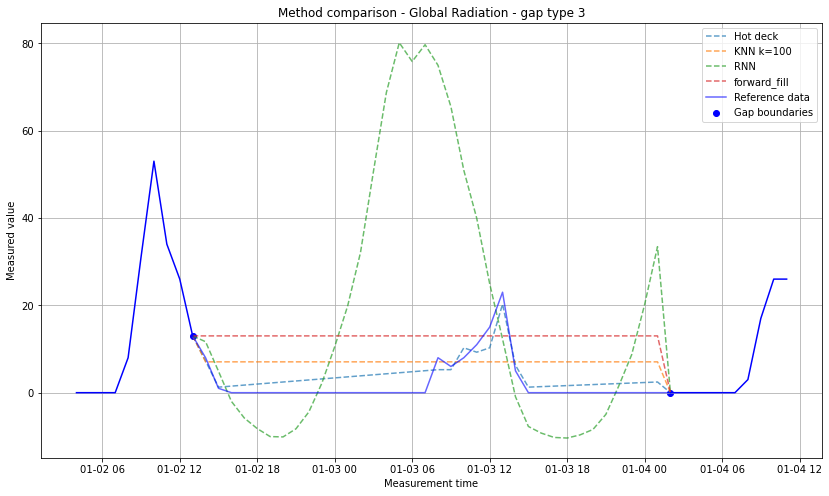

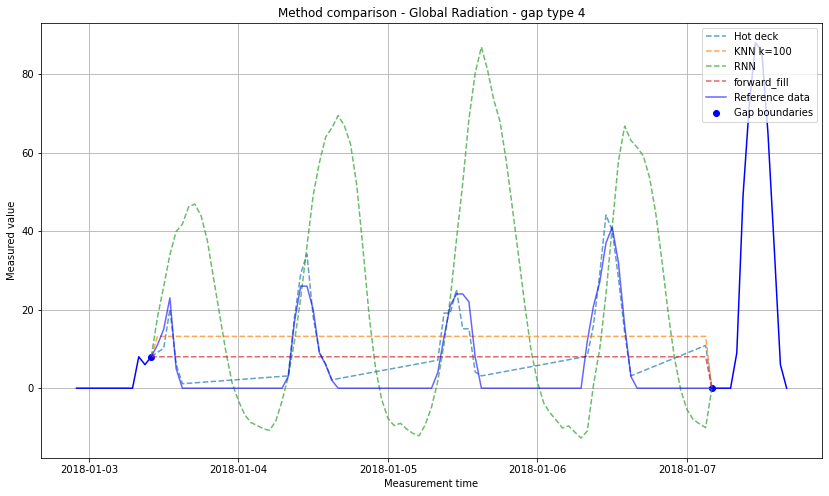

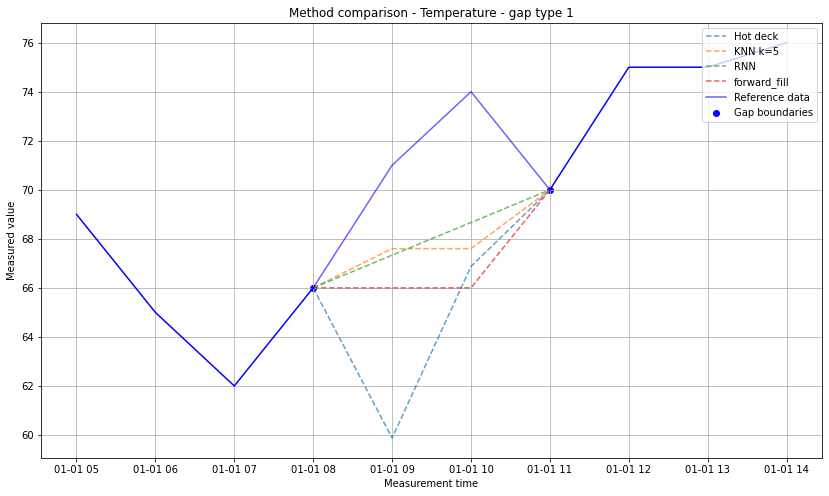

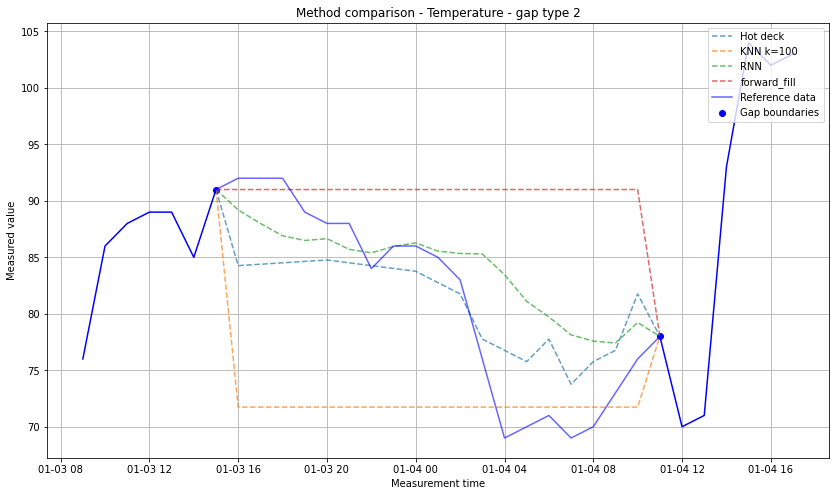

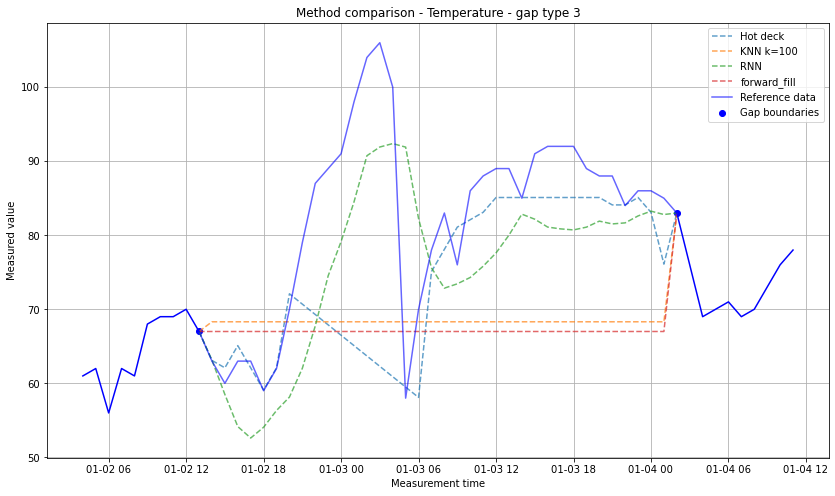

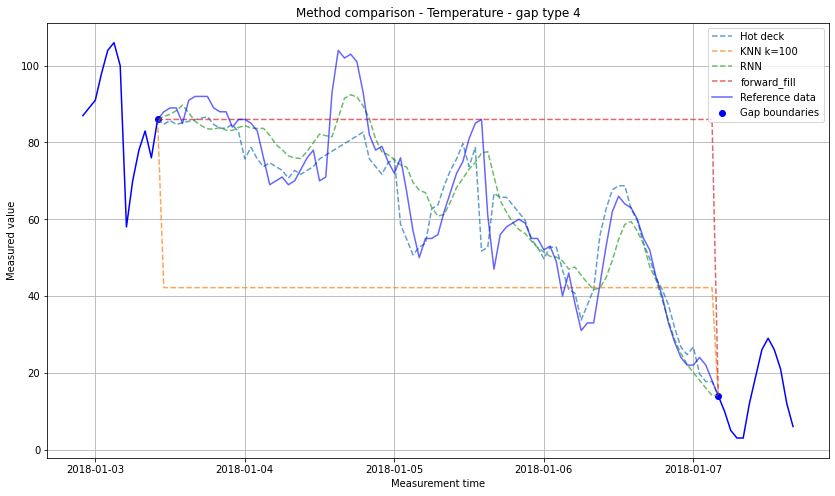

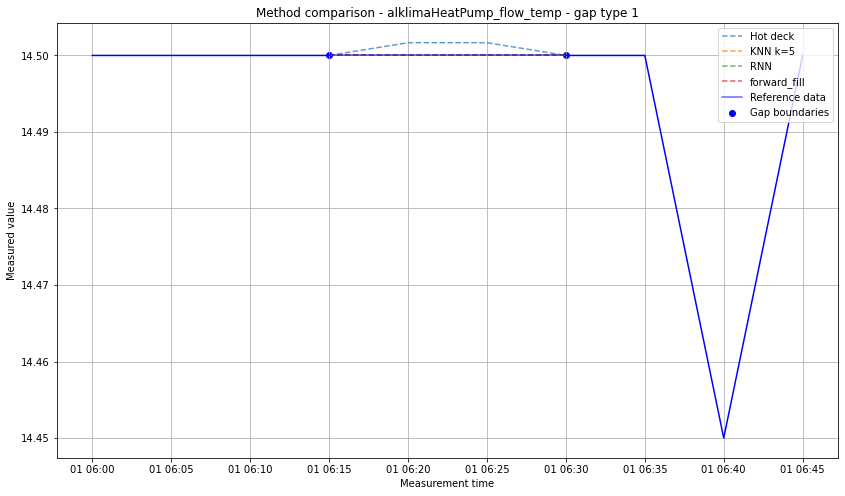

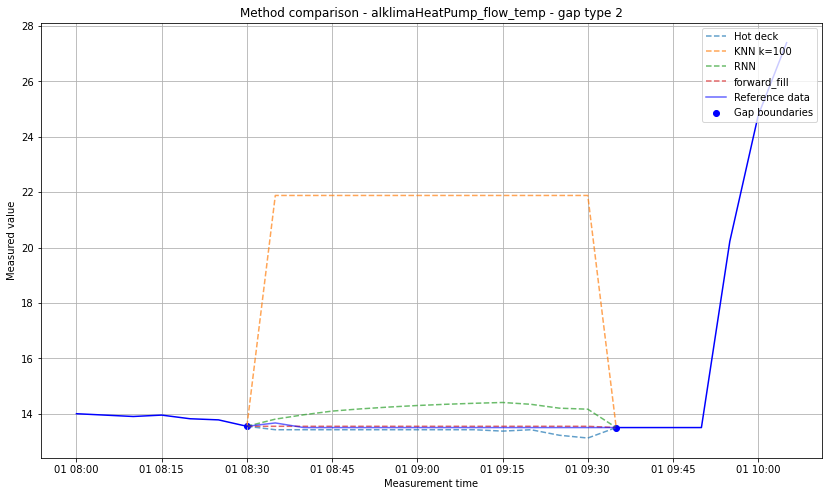

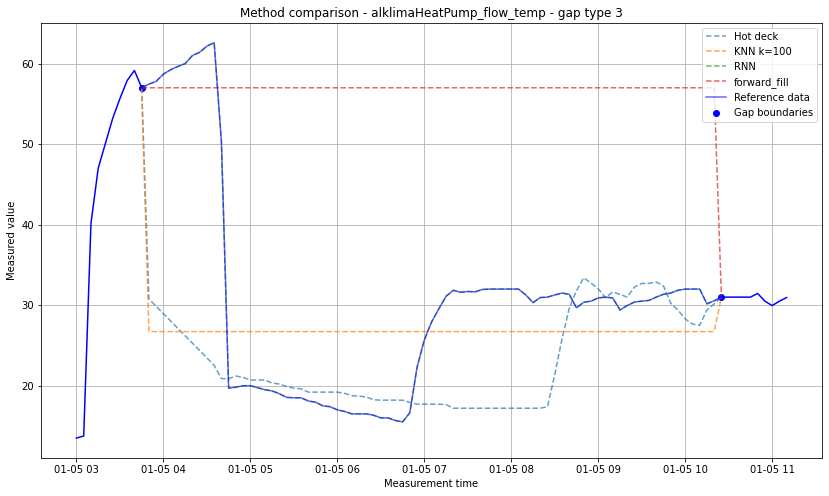

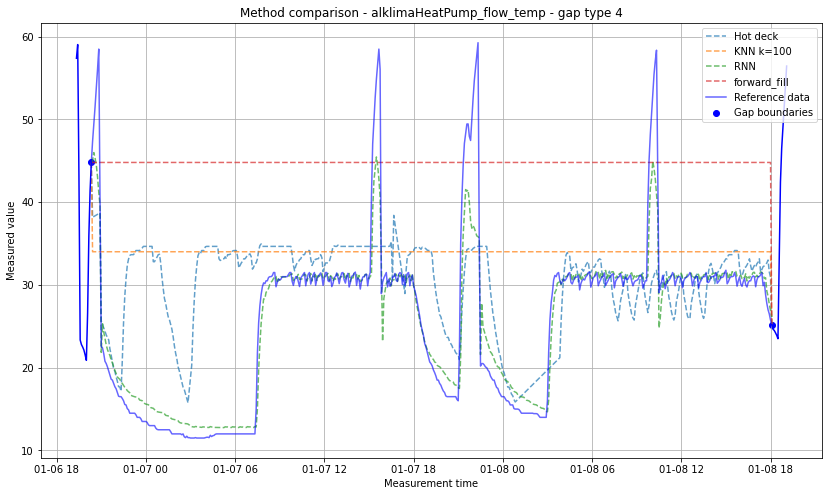

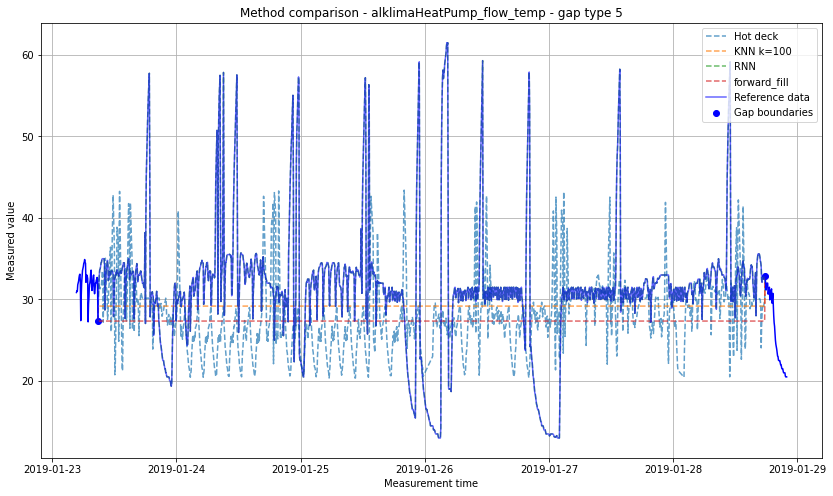

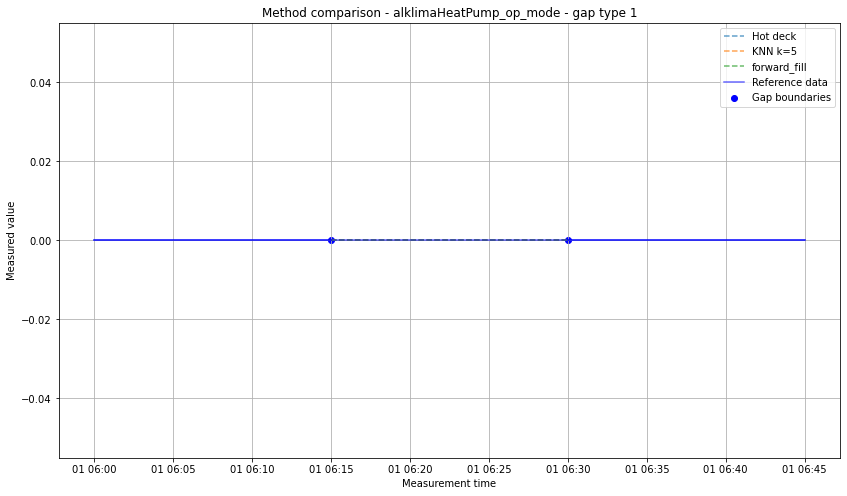

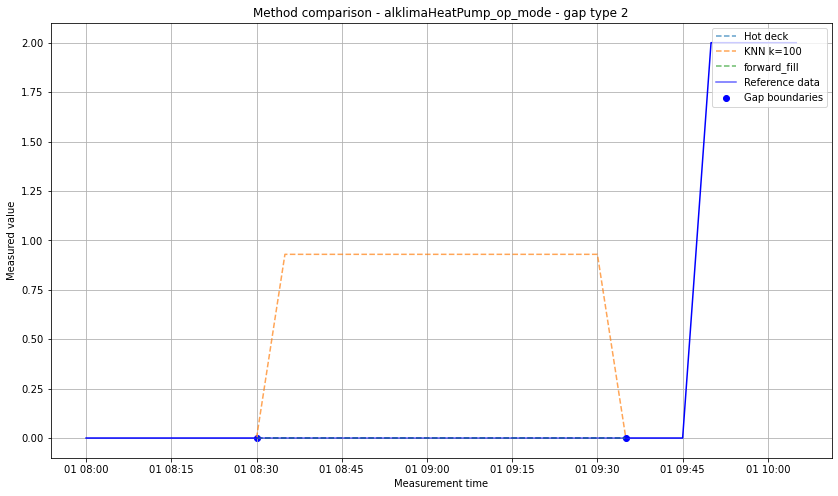

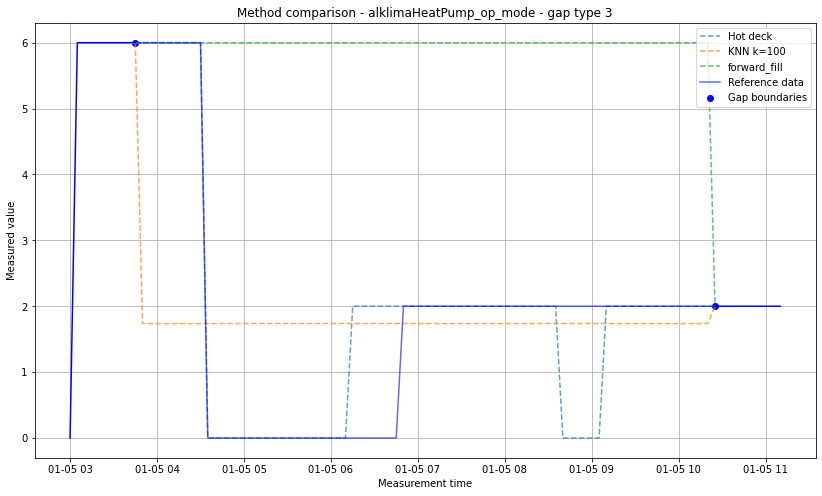

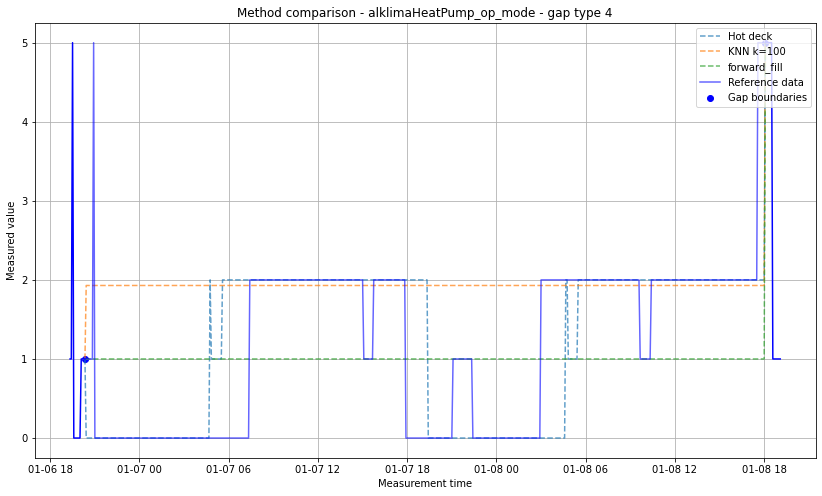

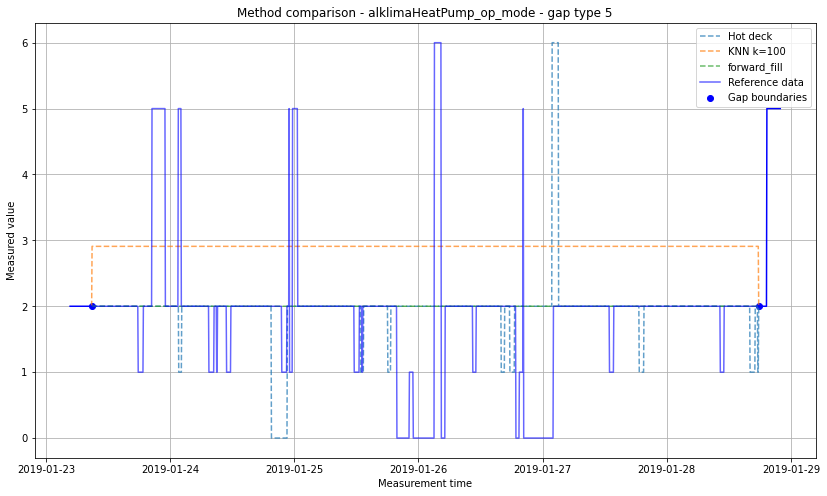

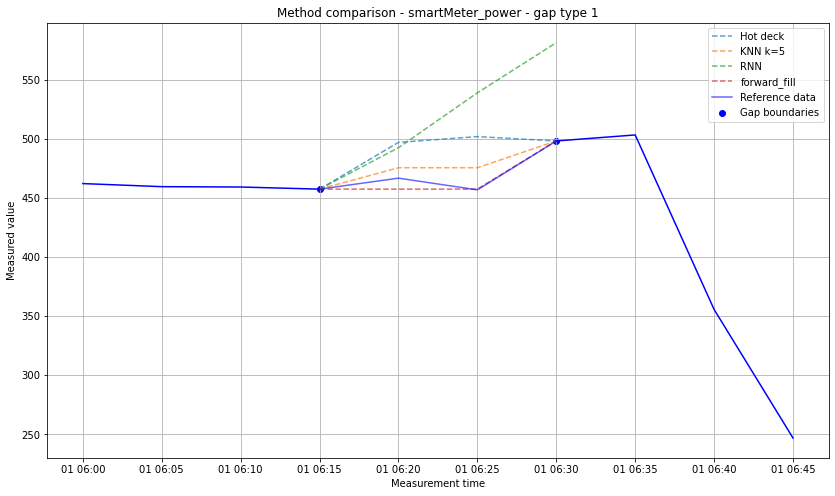

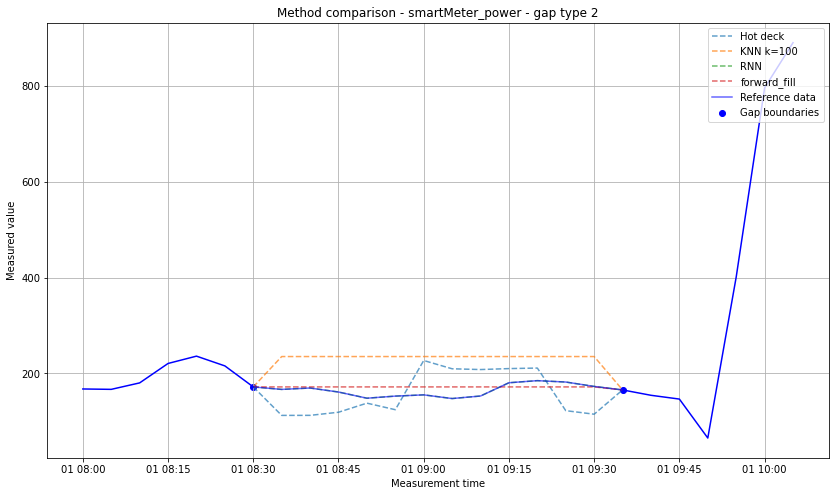

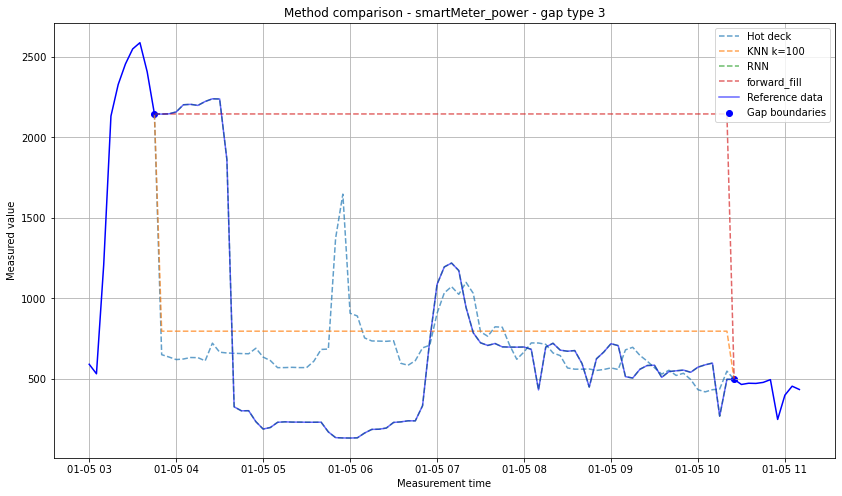

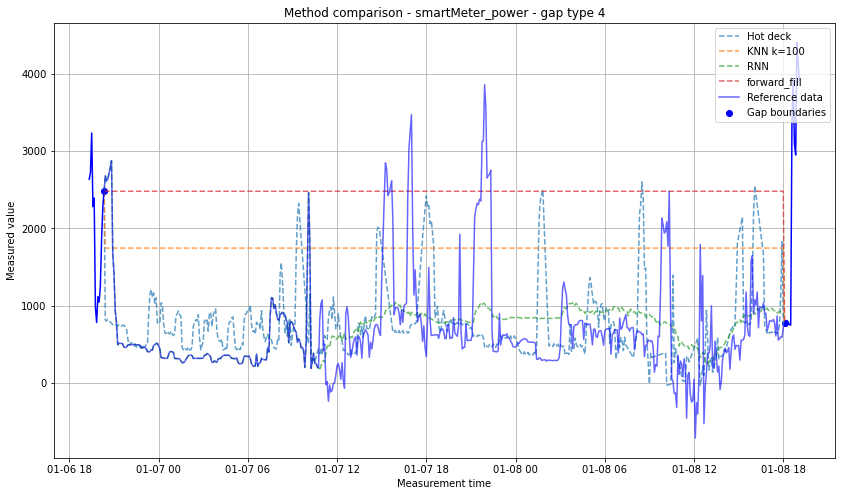

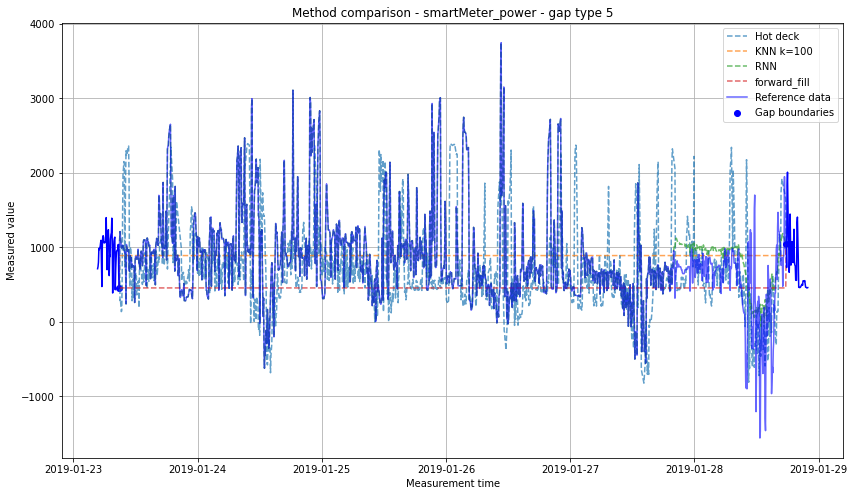

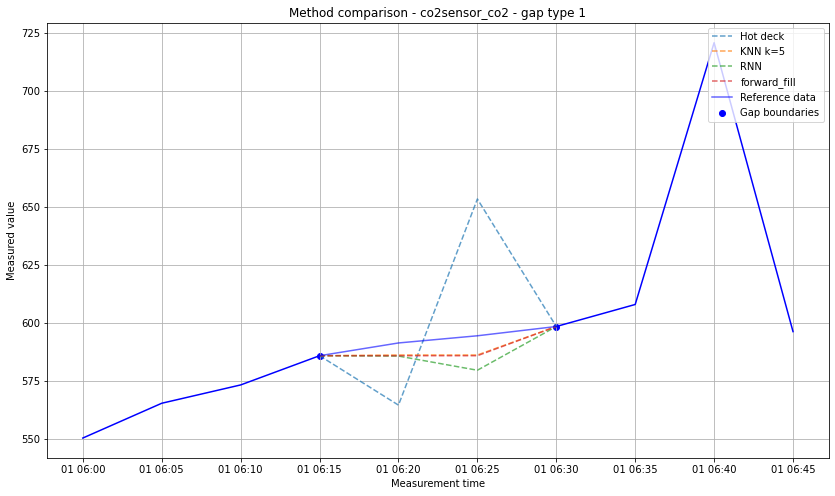

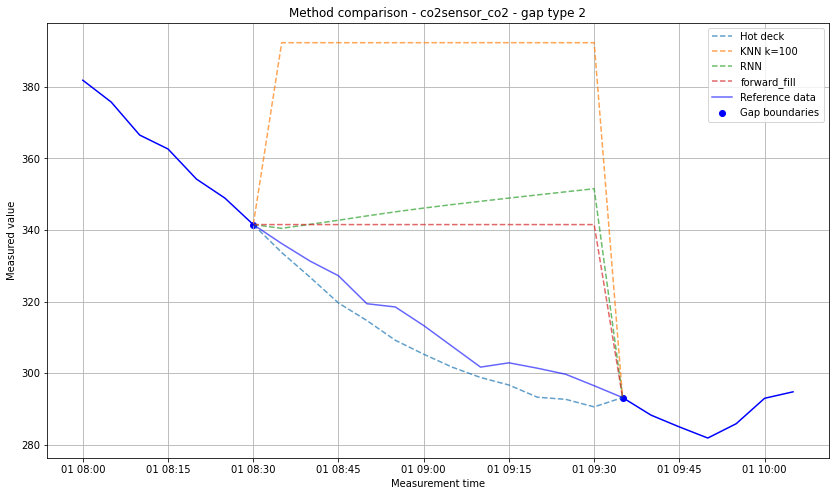

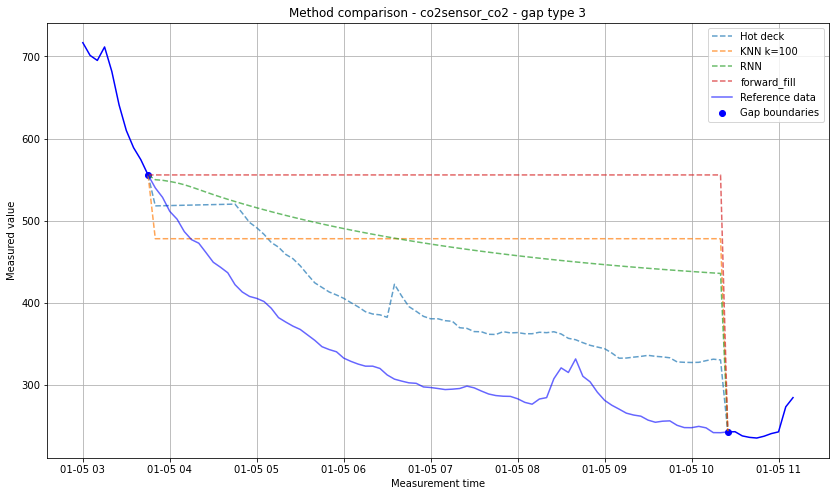

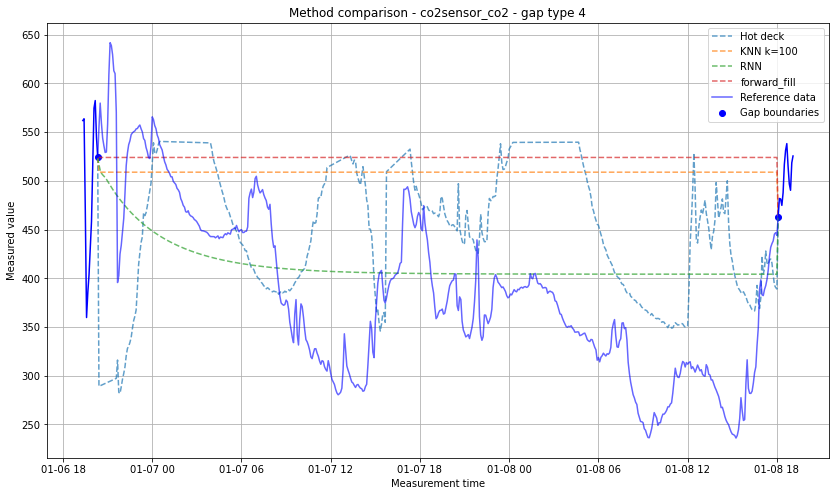

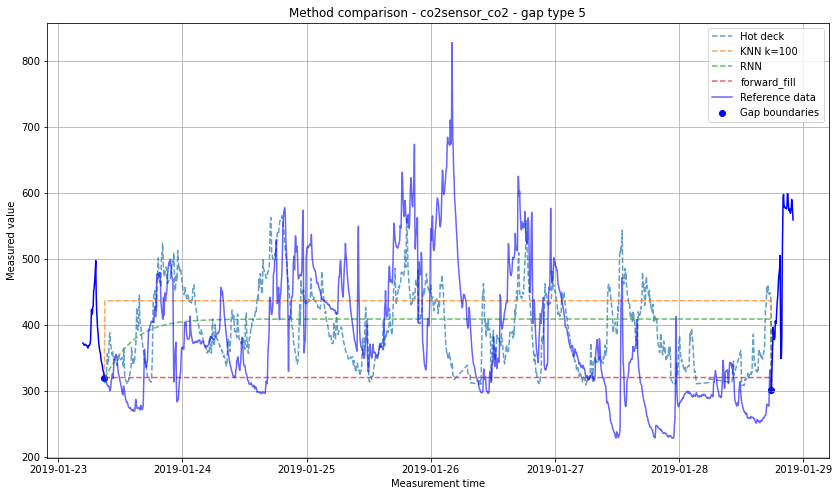

In [1]:
%matplotlib inline

import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from cycler import cycler

devNullOutput = widgets.Output()

gap_types = [1, 2, 3, 4, 5]

configs = [
    {
        "conf": "knmi",
        "file": "260 De Bilt.csv",
        "target": "Relative atmospheric humidity",
        "sheet_name": None
    },
    {
        "conf": "knmi",
        "file": "260 De Bilt.csv",
        "target": "Global Radiation",
        "sheet_name": None
    },
    {
        "conf": "knmi",
        "file": "260 De Bilt.csv",
        "target": "Temperature",
        "sheet_name": None
    },
    {
        "conf": "factory zero",
        "file": "099.xlsx",
        "target": "flow_temp",
        "sheet_name": "alklimaHeatPump"
    },
    {
        "conf": "factory zero",
        "file": "099.xlsx",
        "target": "op_mode",
        "sheet_name": "alklimaHeatPump"
    },
    {
        "conf": "factory zero",
        "file": "099.xlsx",
        "target": "power",
        "sheet_name": "smartMeter"
    },
    {
        "conf": "factory zero",
        "file": "099.xlsx",
        "target": "co2",
        "sheet_name": "co2sensor"
    }
]

directories = next(os.walk('saved_results'))[1]

for conf in configs:
    # Load reference the data
    with devNullOutput:
        %run helpers/load_data.ipynb
        config_select.value = conf["conf"]
        file_select.value = conf["file"]
        dfloader.add_targets(conf["target"], sheet_name=conf["sheet_name"])
    target = dfloader.targets[0]
    ref = dfloader.df[target]

    # Load the imputed and gapped data
    gapped = []
    imputed = []
    gaps_indices = []
    for gap_type in gap_types:
        imputed.append(dict())
        for dirname in sorted([it for it in directories if conf["target"] in it]):
            res_file = f"saved_results/{dirname}/Gap type {gap_type}.csv"
            if not os.path.isfile(res_file) \
                or ("forward_fill" not in dirname \
                and ("KNN k=5" not in dirname or gap_type != 1) \
                and ("KNN k=100" not in dirname or gap_type == 1) \
                and ("RNN" not in dirname or conf["target"] == "op_mode") \
                and "Hot deck" not in dirname):
                continue
            df = pd.read_csv(res_file, sep=";", index_col=0)
            df.index = pd.to_datetime(df.index)
            method = dirname.split(" - ")[0]
            imputed[-1][method] = df[f"Imputed {target}"]
            if len(gapped) != gap_type:
                gapped.append(df[f"Gapped {target}"])

        # Recover gaps indices and find indices to zoom-in on the first gap
        gaps_indices.append([])
        nans_indices = np.where(gapped[-1].isna().values)[0]
        nans_indices_len = len(nans_indices)
        idx = 0
        while idx < nans_indices_len:
            start = idx
            idx += 1
            while idx < nans_indices_len and nans_indices[idx] - nans_indices[idx - 1] == 1:
                idx += 1
            gaps_indices[-1].append(nans_indices[start:idx])

    # Plot
    for i in range(len(gapped)):
        title = f"Method comparison - {target} - gap type {i + 1}"
        plt.subplots(figsize=(14, 8))

        # Imputed
        start = gaps_indices[i][0][0] - 1
        end = gaps_indices[i][0][-1] + 2
        for method, df in imputed[i].items():
            plt.plot(df.iloc[start:end], alpha=0.7, label=method, ls='--')

        # Inside the gap
        plt.plot(ref.iloc[start:end], label="Reference data", color="b", alpha=0.6)
        plt.scatter([ref.index[start]], ref.iloc[start:start + 1], label="Gap boundaries", color='b', alpha=1)
        plt.scatter([ref.index[end - 1]], ref.iloc[end - 1:end], color='b', alpha=1)

        # Arround the gap
        surrounding = 3 * (i + 1) if i != 4 else 50
        start = max(0, start - surrounding)
        end = min(len(ref.index), end + surrounding)
        gapped_view = gapped[i].iloc[start:end]
        plt.plot(gapped_view, color="b")

        plt.title(title)
        plt.xlabel("Measurement time")
        plt.ylabel("Measured value")
        plt.grid(True)
        plt.legend(loc=1)
        plt.savefig(f"visualizations/{title}.png", dpi=300)
        plt.show()
